<a href="https://colab.research.google.com/github/Pritam-BA/DAY1/blob/main/DAY17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def create_shoppers_stop_data():
    """Create realistic Shoppers Stop customer dataset"""
    n_customers = 800

    # Customer demographics and behavior patterns
    # Age distribution reflecting Indian urban shopping demographics
    ages = np.random.normal(35, 12, n_customers).clip(18, 70).astype(int)

    # Annual spending with realistic distribution for premium retail
    # Higher spending for older, affluent customers
    base_spending = np.random.lognormal(mean=10.5, sigma=0.8, size=n_customers)
    age_factor = (ages - 25) * 800  # Age premium
    annual_spending = (base_spending + age_factor).clip(5000, 500000)

    # Visit frequency influenced by age and spending
    visit_freq = np.random.poisson(8, n_customers) + (annual_spending > 50000).astype(int) * 3
    visit_freq = visit_freq.clip(1, 30)

    # Additional realistic features
    cities = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Hyderabad', 'Pune']
    membership_types = ['Silver', 'Gold', 'Platinum']

    # Create customer dataset
    customer_data = pd.DataFrame({
        'customer_id': range(1, n_customers + 1),
        'age': ages,
        'annual_spending': annual_spending.round(0),
        'visit_frequency': visit_freq,
        'city': np.random.choice(cities, n_customers),
        'membership_type': np.random.choice(membership_types, n_customers, p=[0.6, 0.3, 0.1]),
        'avg_transaction_value': (annual_spending / visit_freq).round(0),
        'years_as_customer': np.random.randint(1, 10, n_customers),
        'preferred_category': np.random.choice(['Fashion', 'Beauty', 'Home', 'Accessories'], n_customers)
    })

    return customer_data

# Create the dataset
shoppers_data = create_shoppers_stop_data()
print("Shoppers Stop Customer Dataset Created!")
print(f"Dataset Shape: {shoppers_data.shape}")
print("\nFirst 5 customers:")
print(shoppers_data.head())


Shoppers Stop Customer Dataset Created!
Dataset Shape: (800, 9)

First 5 customers:
   customer_id  age  annual_spending  visit_frequency       city  \
0            1   40          88928.0                9  Hyderabad   
1            2   33          30433.0               11  Bangalore   
2            3   42          52818.0               11      Delhi   
3            4   53          47489.0               12    Chennai   
4            5   32          31253.0                9      Delhi   

  membership_type  avg_transaction_value  years_as_customer preferred_category  
0            Gold                 9881.0                  7               Home  
1            Gold                 2767.0                  3            Fashion  
2          Silver                 4802.0                  2             Beauty  
3            Gold                 3957.0                  2             Beauty  
4          Silver                 3473.0                  8             Beauty  


In [2]:
print("\n" + "="*60)
print("=== DATA PREPARATION & EXPLORATION ===")
print("="*60)

# Basic statistics
print("Dataset Statistics:")
print(shoppers_data.describe())

# Correlation analysis for clustering features
clustering_features = ['annual_spending', 'visit_frequency', 'avg_transaction_value', 'age']
correlation_matrix = shoppers_data[clustering_features].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# City-wise analysis
city_analysis = shoppers_data.groupby('city').agg({
    'annual_spending': 'mean',
    'visit_frequency': 'mean',
    'customer_id': 'count'
}).round(2)
city_analysis.columns = ['Avg_Spending', 'Avg_Visits', 'Customer_Count']

print(f"\nCity-wise Customer Analysis:")
print(city_analysis.sort_values('Avg_Spending', ascending=False))

# Membership analysis
membership_analysis = shoppers_data.groupby('membership_type').agg({
    'annual_spending': ['mean', 'count'],
    'visit_frequency': 'mean'
}).round(2)

print(f"\nMembership Type Analysis:")
print(membership_analysis)



=== DATA PREPARATION & EXPLORATION ===
Dataset Statistics:
       customer_id         age  annual_spending  visit_frequency  \
count     800.0000  800.000000       800.000000       800.000000   
mean      400.5000   34.792500     61151.463750         9.270000   
std       231.0844   11.036834     47649.859831         3.014707   
min         1.0000   18.000000      5000.000000         2.000000   
25%       200.7500   26.000000     29893.000000         7.000000   
50%       400.5000   35.000000     47495.500000         9.000000   
75%       600.2500   42.000000     75886.000000        11.000000   
max       800.0000   70.000000    300406.000000        19.000000   

       avg_transaction_value  years_as_customer  
count             800.000000         800.000000  
mean             6811.001250           4.981250  
std              5386.668318           2.553733  
min               455.000000           1.000000  
25%              3633.000000           3.000000  
50%              5354.00000

In [3]:
print("\n" + "="*60)
print("=== FEATURE SELECTION & SCALING ===")
print("="*60)

# Select key features for clustering
# Focus on spending behavior and engagement
features_for_clustering = ['annual_spending', 'visit_frequency']
X = shoppers_data[features_for_clustering].copy()

print("Features selected for clustering:")
print(X.head())

# Check for outliers using IQR method
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

print(f"\nOutlier Analysis:")
for feature in features_for_clustering:
    outlier_count = detect_outliers(X, feature)
    print(f"{feature}: {outlier_count} outliers ({outlier_count/len(X)*100:.1f}%)")

# Scale features for K-means (important for distance-based algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures scaled using StandardScaler")
print(f"Original feature ranges:")
for i, feature in enumerate(features_for_clustering):
    print(f"{feature}: {X[feature].min():.0f} - {X[feature].max():.0f}")

print(f"\nScaled feature ranges:")
scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
for i, feature in enumerate(features_for_clustering):
    print(f"{feature}: {scaled_df[feature].min():.2f} - {scaled_df[feature].max():.2f}")



=== FEATURE SELECTION & SCALING ===
Features selected for clustering:
   annual_spending  visit_frequency
0          88928.0                9
1          30433.0               11
2          52818.0               11
3          47489.0               12
4          31253.0                9

Outlier Analysis:
annual_spending: 47 outliers (5.9%)
visit_frequency: 2 outliers (0.2%)

Features scaled using StandardScaler
Original feature ranges:
annual_spending: 5000 - 300406
visit_frequency: 2 - 19

Scaled feature ranges:
annual_spending: -1.18 - 5.02
visit_frequency: -2.41 - 3.23


In [4]:
print("\n" + "="*60)
print("=== DETERMINING OPTIMAL CLUSTERS ===")
print("="*60)

# Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Find optimal k using elbow method
print("Elbow Method Results:")
for k, inertia, sil_score in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.3f}")

# Select optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")



=== DETERMINING OPTIMAL CLUSTERS ===
Elbow Method Results:
k=2: Inertia=895.69, Silhouette Score=0.419
k=3: Inertia=562.34, Silhouette Score=0.435
k=4: Inertia=441.30, Silhouette Score=0.367
k=5: Inertia=348.67, Silhouette Score=0.387
k=6: Inertia=286.18, Silhouette Score=0.378
k=7: Inertia=243.77, Silhouette Score=0.383
k=8: Inertia=216.45, Silhouette Score=0.383
k=9: Inertia=194.94, Silhouette Score=0.352
k=10: Inertia=178.97, Silhouette Score=0.348

Optimal number of clusters: 3
Best Silhouette Score: 0.435


In [5]:
print("\n" + "="*60)
print("=== K-MEANS CLUSTERING IMPLEMENTATION ===")
print("="*60)

# Apply K-means with optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
shoppers_data['cluster'] = kmeans_final.fit_predict(X_scaled)

# Analyze cluster characteristics
cluster_analysis = shoppers_data.groupby('cluster').agg({
    'annual_spending': ['count', 'mean', 'median', 'std'],
    'visit_frequency': ['mean', 'median'],
    'age': 'mean',
    'avg_transaction_value': 'mean'
}).round(2)

cluster_analysis.columns = ['Customer_Count', 'Avg_Spending', 'Median_Spending', 'Spending_Std',
                           'Avg_Visits', 'Median_Visits', 'Avg_Age', 'Avg_Transaction_Value']

print("Cluster Analysis:")
print(cluster_analysis)

# Calculate cluster centers in original scale
cluster_centers_scaled = kmeans_final.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

print(f"\nCluster Centers (Original Scale):")
for i, center in enumerate(cluster_centers_original):
    print(f"Cluster {i}: Spending=₹{center[0]:,.0f}, Visits={center[1]:.1f}")

# Assign meaningful cluster names
cluster_names = {}
for i in range(optimal_k):
    spending = cluster_centers_original[i][0]
    visits = cluster_centers_original[i][1]

    if spending > 80000 and visits > 12:
        cluster_names[i] = "VIP Customers"
    elif spending > 50000:
        cluster_names[i] = "High-Value Customers"
    elif visits > 10:
        cluster_names[i] = "Frequent Shoppers"
    else:
        cluster_names[i] = "Occasional Customers"

shoppers_data['cluster_name'] = shoppers_data['cluster'].map(cluster_names)

print(f"\nCluster Names and Distribution:")
cluster_distribution = shoppers_data['cluster_name'].value_counts()
for cluster_name, count in cluster_distribution.items():
    percentage = (count / len(shoppers_data)) * 100
    print(f"{cluster_name}: {count} customers ({percentage:.1f}%)")



=== K-MEANS CLUSTERING IMPLEMENTATION ===
Cluster Analysis:
         Customer_Count  Avg_Spending  Median_Spending  Spending_Std  \
cluster                                                                
0                   319      59787.98          59666.0      23499.79   
1                   379      35412.14          33306.0      18462.16   
2                   102     161054.93         142595.0      48743.17   

         Avg_Visits  Median_Visits  Avg_Age  Avg_Transaction_Value  
cluster                                                             
0             11.68           11.0    36.82                5240.27  
1              6.83            7.0    32.63                5630.64  
2             10.78           11.0    36.49               16109.23  

Cluster Centers (Original Scale):
Cluster 0: Spending=₹59,788, Visits=11.7
Cluster 1: Spending=₹35,412, Visits=6.8
Cluster 2: Spending=₹161,055, Visits=10.8

Cluster Names and Distribution:
High-Value Customers: 421 customers (52.6%

In [6]:
print("\n" + "="*60)
print("=== ADVANCED CLUSTER ANALYSIS ===")
print("="*60)

# Demographic analysis by cluster
demographic_analysis = shoppers_data.groupby('cluster_name').agg({
    'age': ['mean', 'std'],
    'years_as_customer': 'mean',
    'city': lambda x: x.value_counts().index[0],  # Most common city
    'membership_type': lambda x: x.value_counts().index[0],  # Most common membership
    'preferred_category': lambda x: x.value_counts().index[0]  # Most common category
}).round(2)

print("Demographic Profile by Cluster:")
print(demographic_analysis)

# Revenue contribution analysis
revenue_analysis = shoppers_data.groupby('cluster_name').agg({
    'annual_spending': 'sum',
    'customer_id': 'count'
})
revenue_analysis['Revenue_Share'] = (revenue_analysis['annual_spending'] /
                                   revenue_analysis['annual_spending'].sum() * 100).round(1)
revenue_analysis['Avg_Revenue_Per_Customer'] = (revenue_analysis['annual_spending'] /
                                               revenue_analysis['customer_id']).round(0)

print(f"\nRevenue Contribution by Cluster:")
print(revenue_analysis)

# Customer lifetime value estimation
shoppers_data['estimated_clv'] = (shoppers_data['annual_spending'] *
                                 shoppers_data['years_as_customer'])

clv_analysis = shoppers_data.groupby('cluster_name')['estimated_clv'].agg(['mean', 'median']).round(0)
print(f"\nEstimated Customer Lifetime Value by Cluster:")
print(clv_analysis)

# Business insights
total_revenue = shoppers_data['annual_spending'].sum()
print(f"\n=== KEY BUSINESS METRICS ===")
print(f"💰 Total Annual Revenue: ₹{total_revenue:,.0f}")
print(f"👥 Total Customers: {len(shoppers_data):,}")
print(f"📊 Average Revenue per Customer: ₹{total_revenue/len(shoppers_data):,.0f}")
print(f"🎯 Cluster Quality (Silhouette): {max(silhouette_scores):.3f}")

# Most valuable segment
most_valuable_cluster = revenue_analysis['Revenue_Share'].idxmax()
print(f"🏆 Most Valuable Segment: {most_valuable_cluster} ({revenue_analysis.loc[most_valuable_cluster, 'Revenue_Share']:.1f}% of revenue)")



=== ADVANCED CLUSTER ANALYSIS ===
Demographic Profile by Cluster:
                        age        years_as_customer       city  \
                       mean    std              mean   <lambda>   
cluster_name                                                      
High-Value Customers  36.74  11.06              4.74  Bangalore   
Occasional Customers  32.63  10.62              5.25  Hyderabad   

                     membership_type preferred_category  
                            <lambda>           <lambda>  
cluster_name                                             
High-Value Customers          Silver               Home  
Occasional Customers          Silver               Home  

Revenue Contribution by Cluster:
                      annual_spending  customer_id  Revenue_Share  \
cluster_name                                                        
High-Value Customers       35499970.0          421           72.6   
Occasional Customers       13421201.0          379           27.4 

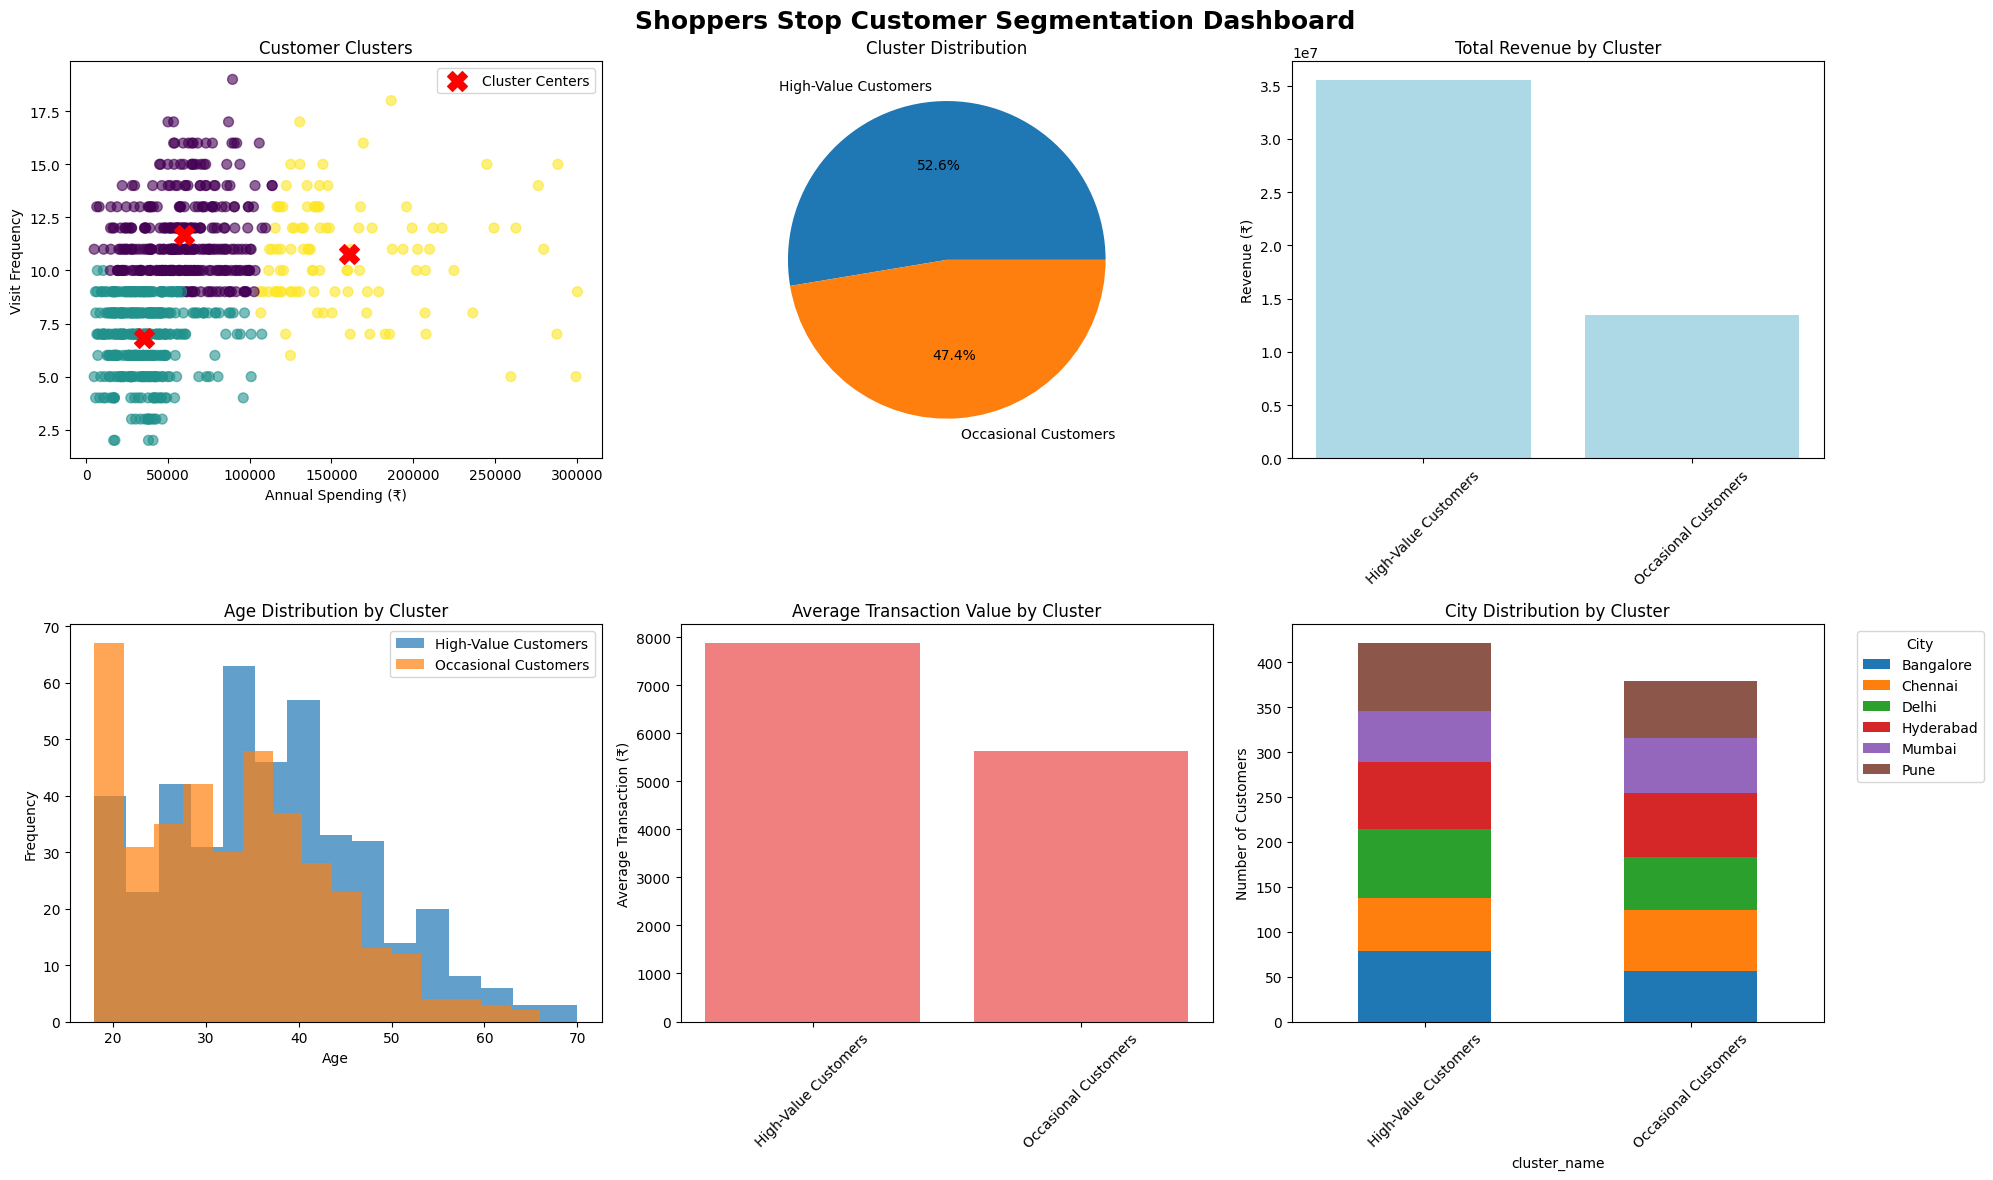

In [7]:
# Create comprehensive clustering visualization dashboard
def create_clustering_dashboard(data, centers):
    """Generate comprehensive customer segmentation dashboard"""

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Shoppers Stop Customer Segmentation Dashboard', fontsize=18, fontweight='bold')

    # 1. Cluster Scatter Plot
    scatter = axes[0, 0].scatter(data['annual_spending'], data['visit_frequency'],
                               c=data['cluster'], cmap='viridis', alpha=0.6, s=50)
    axes[0, 0].scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200,
                      label='Cluster Centers')
    axes[0, 0].set_xlabel('Annual Spending (₹)')
    axes[0, 0].set_ylabel('Visit Frequency')
    axes[0, 0].set_title('Customer Clusters')
    axes[0, 0].legend()

    # 2. Cluster Size Distribution
    cluster_counts = data['cluster_name'].value_counts()
    axes[0, 1].pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Cluster Distribution')

    # 3. Revenue by Cluster
    revenue_by_cluster = data.groupby('cluster_name')['annual_spending'].sum()
    axes[0, 2].bar(revenue_by_cluster.index, revenue_by_cluster.values, color='lightblue')
    axes[0, 2].set_title('Total Revenue by Cluster')
    axes[0, 2].set_ylabel('Revenue (₹)')
    axes[0, 2].tick_params(axis='x', rotation=45)

    # 4. Age Distribution by Cluster
    for i, cluster in enumerate(data['cluster_name'].unique()):
        cluster_data = data[data['cluster_name'] == cluster]
        axes[1, 0].hist(cluster_data['age'], alpha=0.7, label=cluster, bins=15)
    axes[1, 0].set_xlabel('Age')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Age Distribution by Cluster')
    axes[1, 0].legend()

    # 5. Average Transaction Value by Cluster
    avg_transaction = data.groupby('cluster_name')['avg_transaction_value'].mean()
    axes[1, 1].bar(avg_transaction.index, avg_transaction.values, color='lightcoral')
    axes[1, 1].set_title('Average Transaction Value by Cluster')
    axes[1, 1].set_ylabel('Average Transaction (₹)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    # 6. City Distribution by Cluster
    city_cluster = pd.crosstab(data['cluster_name'], data['city'])
    city_cluster.plot(kind='bar', stacked=True, ax=axes[1, 2])
    axes[1, 2].set_title('City Distribution by Cluster')
    axes[1, 2].set_ylabel('Number of Customers')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Generate the dashboard
create_clustering_dashboard(shoppers_data, cluster_centers_original)
